# Cooking with Leftover Ingredients
## Samuel Nguyen
## June 27th, 2021

# Table of Contents

1. [EDA & Cleaning](#eda) <br>
2. [Cuisine Classification](#Feature-Engineering)
3. [Modelling](#Modelling) <br>
    3.1 [Logistic Regression](#LR) <br>
    3.2 [Decision Tree](#DT) <br>
    3.3 [Random Forest Classifier](#RF) <br>

In [1]:
# Import necessary packages for exploratory data analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import boto3

The purpose of this analysis is to utilize machine learning to predict what type of cuisine you can create using leftover ingredients at home.

In order to do so, I utilized the datasets found at https://www.kaggle.com/shuyangli94/food-com-recipes-and-user-interactions to perform exploratory data analysis as well as train my models. This capstone was conducted on AWS Sagemaker, using the ml.m5.4xlarge instance.

For this capstone I decided to store my data on an s3 bucket. First, I will instantiate an s3 client and grab the necessary dataset(s) I need to continue with my exploratory data analysis.

In [2]:
# Instantiate s3 client
s3 = boto3.client('s3')

# Send request to list buckets and assign to a variable
response = s3.list_buckets()

# Grab specific files from specified bucket
obj = s3.get_object(Bucket = 'sam-bstncapstone-bucket',Key = 'RAW_recipes.csv')
obj2 = s3.get_object(Bucket = 'sam-bstncapstone-bucket',Key = 'PP_recipes.csv')

# Read csv into dataframe
raw_recipes = pd.read_csv(obj['Body'],converters = {'tags': eval, 'ingredients':eval})
pp_recipes = pd.read_csv(obj2['Body'])

Now that I have read in the data, let's take a closer look at the data.

# Exploratory Data Analysis and Cleaning 
<a id='eda'></a>

In [3]:
# Take a look at the data
raw_recipes.head()

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients
0,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"[60-minutes-or-less, time-to-make, course, mai...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,"[winter squash, mexican seasoning, mixed spice...",7
1,a bit different breakfast pizza,31490,30,26278,2002-06-17,"[30-minutes-or-less, time-to-make, course, mai...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,"[prepared pizza crust, sausage patty, eggs, mi...",6
2,all in the kitchen chili,112140,130,196586,2005-02-25,"[time-to-make, course, preparation, main-dish,...","[269.8, 22.0, 32.0, 48.0, 39.0, 27.0, 5.0]",6,"['brown ground beef in large pot', 'add choppe...",this modified version of 'mom's' chili was a h...,"[ground beef, yellow onions, diced tomatoes, t...",13
3,alouette potatoes,59389,45,68585,2003-04-14,"[60-minutes-or-less, time-to-make, course, mai...","[368.1, 17.0, 10.0, 2.0, 14.0, 8.0, 20.0]",11,['place potatoes in a large pot of lightly sal...,"this is a super easy, great tasting, make ahea...","[spreadable cheese with garlic and herbs, new ...",11
4,amish tomato ketchup for canning,44061,190,41706,2002-10-25,"[weeknight, time-to-make, course, main-ingredi...","[352.9, 1.0, 337.0, 23.0, 3.0, 0.0, 28.0]",5,['mix all ingredients& boil for 2 1 / 2 hours ...,my dh's amish mother raised him on this recipe...,"[tomato juice, apple cider vinegar, sugar, sal...",8


In [4]:
# Look at rows and columns of data
raw_recipes.shape

(231637, 12)

In [5]:
# Check null values values
print(raw_recipes.isna().sum())

name                 1
id                   0
minutes              0
contributor_id       0
submitted            0
tags                 0
nutrition            0
n_steps              0
steps                0
description       4979
ingredients          0
n_ingredients        0
dtype: int64


In [6]:
# Check proportion of null values
raw_recipes.isna().mean()

name              0.000004
id                0.000000
minutes           0.000000
contributor_id    0.000000
submitted         0.000000
tags              0.000000
nutrition         0.000000
n_steps           0.000000
steps             0.000000
description       0.021495
ingredients       0.000000
n_ingredients     0.000000
dtype: float64

The `raw_recipes` dataset is very clean so far! There are total of 231637 rows, and 12 columns.

The only null/missing values are:

- 1 recipe name
- 4979 recipe descriptions (0.021495% of total data)

This data also comes with pre-tokenized and cleaned data in `pp_recipes`, so I will take a look at that as well.

In [7]:
# Look at pp_recipes
pp_recipes.head()

,id,i,name_tokens,ingredient_tokens,steps_tokens,techniques,calorie_level,ingredient_ids
0,424415,23,"[40480, 37229, 2911, 1019, 249, 6878, 6878, 28...","[[2911, 1019, 249, 6878], [1353], [6953], [153...","[40480, 40482, 21662, 481, 6878, 500, 246, 161...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",0,"[389, 7655, 6270, 1527, 3406]"
1,146223,96900,"[40480, 18376, 7056, 246, 1531, 2032, 40481]","[[17918], [25916], [2507, 6444], [8467, 1179],...","[40480, 40482, 729, 2525, 10906, 485, 43, 8393...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",0,"[2683, 4969, 800, 5298, 840, 2499, 6632, 7022,..."
2,312329,120056,"[40480, 21044, 16954, 8294, 556, 10837, 40481]","[[5867, 24176], [1353], [6953], [1301, 11332],...","[40480, 40482, 8240, 481, 24176, 296, 1353, 66...","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...",1,"[1257, 7655, 6270, 590, 5024, 1119, 4883, 6696..."
3,74301,168258,"[40480, 10025, 31156, 40481]","[[1270, 1645, 28447], [21601], [27952, 29471, ...","[40480, 40482, 5539, 21601, 1073, 903, 2324, 4...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,"[7940, 3609, 7060, 6265, 1170, 6654, 5003, 3561]"
4,76272,109030,"[40480, 17841, 252, 782, 2373, 1641, 2373, 252...","[[1430, 11434], [1430, 17027], [1615, 23, 695,...","[40480, 40482, 14046, 1430, 11434, 488, 17027,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",0,"[3484, 6324, 7594, 243]"


In [8]:
# Look at shape 
pp_recipes.shape

(178265, 8)

In [9]:
# Check null values 
pp_recipes.isna().sum()

id                   0
i                    0
name_tokens          0
ingredient_tokens    0
steps_tokens         0
techniques           0
calorie_level        0
ingredient_ids       0
dtype: int64

In [10]:
# Check duplicated values
print(f'There are {pp_recipes.duplicated().sum()} duplicated rows')

There are 0 duplicated rows


This looks great! The `pp_recipes` data is clean with no null or duplicated values. There are a total of 178265 rows, and 8 columns in this dataset. This data is all converted to numerical values however, so I will merge it with the `raw_recipes` dataframe to interpret the data more easily. The new merged dataset will be named `raw_recipes`.

In [11]:
# Merge datasets together
raw_recipes = pd.merge(raw_recipes,pp_recipes, on = 'id')

In [12]:
# Sanity check
raw_recipes.head()

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients,i,name_tokens,ingredient_tokens,steps_tokens,techniques,calorie_level,ingredient_ids
0,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"[60-minutes-or-less, time-to-make, course, mai...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,"[winter squash, mexican seasoning, mixed spice...",7,145702,"[40480, 1943, 6987, 12187, 4423, 23841, 12432,...","[[4423, 23841], [12432, 29471, 484], [5811, 16...","[40480, 40482, 925, 246, 2650, 488, 10744, 556...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,"[7933, 4694, 4795, 3723, 840, 5006, 6270]"
1,a bit different breakfast pizza,31490,30,26278,2002-06-17,"[30-minutes-or-less, time-to-make, course, mai...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,"[prepared pizza crust, sausage patty, eggs, mi...",6,33090,"[40480, 246, 1378, 1685, 3511, 6856, 40481]","[[3572, 6856, 19093], [17027, 15774], [6812], ...","[40480, 40482, 729, 2525, 10906, 485, 44, 1035...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,"[5481, 6324, 2499, 4717, 6276, 1170]"
2,alouette potatoes,59389,45,68585,2003-04-14,"[60-minutes-or-less, time-to-make, course, mai...","[368.1, 17.0, 10.0, 2.0, 14.0, 8.0, 20.0]",11,['place potatoes in a large pot of lightly sal...,"this is a super easy, great tasting, make ahea...","[spreadable cheese with garlic and herbs, new ...",11,44921,"[40480, 501, 482, 3561, 10837, 40481]","[[582, 14754, 6821, 556, 15022, 488, 13747], [...","[40480, 40482, 1082, 10837, 500, 246, 1719, 50...","[1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...",1,"[1170, 4918, 6426, 5185, 7099, 5006, 6009, 627..."
3,apple a day milk shake,5289,0,1533,1999-12-06,"[15-minutes-or-less, time-to-make, course, mai...","[160.2, 10.0, 55.0, 3.0, 9.0, 20.0, 7.0]",4,"['combine ingredients in blender', 'cover and ...",NaN,"[milk, vanilla ice cream, frozen apple juice c...",4,28162,"[40480, 7304, 246, 850, 5940, 3033, 40481]","[[5940], [15000, 755, 4914], [4787, 7304, 7524...","[40480, 40482, 23667, 16126, 500, 37588, 40478...","[0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",0,"[4717, 7474, 2946, 150]"
4,aww marinated olives,25274,15,21730,2002-04-14,"[15-minutes-or-less, time-to-make, course, mai...","[380.7, 53.0, 7.0, 24.0, 6.0, 24.0, 6.0]",4,['toast the fennel seeds and lightly crush the...,my italian mil was thoroughly impressed by my ...,"[fennel seeds, green olives, ripe olives, garl...",9,140021,"[40480, 30192, 831, 21375, 30142, 40481]","[[8352, 3098, 14516], [2056, 30142], [13583, 3...","[40480, 40482, 8061, 481, 8352, 3098, 14516, 4...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...",1,"[2587, 3437, 5002, 3184, 5324, 5068, 5058, 131..."


In [13]:
# Check shape of dataframe
raw_recipes.shape

(178265, 19)

In [14]:
# Check nan values
raw_recipes.isna().sum()

name                    0
id                      0
minutes                 0
contributor_id          0
submitted               0
tags                    0
nutrition               0
n_steps                 0
steps                   0
description          3954
ingredients             0
n_ingredients           0
i                       0
name_tokens             0
ingredient_tokens       0
steps_tokens            0
techniques              0
calorie_level           0
ingredient_ids          0
dtype: int64

After merging, the only null values in this `raw_recipes` dataframe are 3954 rows in the `description` column. I will not remove these null values yet, as I do not want to lose any recipes from my dataframe.

The `tags` column provides many different tags that users attached with their recipes. Let's see if there are any tags for cuisines. If so, I can categorize each individual recipes using their cuisine tags.

In [15]:
# Create empty list for tags
tags = []
# Append tags to list
for x in raw_recipes['tags']:
    for y in x:
        tags.append(y)

In [16]:
# Sanity check
tags

['60-minutes-or-less',
 'time-to-make',
 'course',
 'main-ingredient',
 'cuisine',
 'preparation',
 'occasion',
 'north-american',
 'side-dishes',
 'vegetables',
 'mexican',
 'easy',
 'fall',
 'holiday-event',
 'vegetarian',
 'winter',
 'dietary',
 'christmas',
 'seasonal',
 'squash',
 '30-minutes-or-less',
 'time-to-make',
 'course',
 'main-ingredient',
 'cuisine',
 'preparation',
 'occasion',
 'north-american',
 'breakfast',
 'main-dish',
 'pork',
 'american',
 'oven',
 'easy',
 'kid-friendly',
 'pizza',
 'dietary',
 'northeastern-united-states',
 'meat',
 'equipment',
 '60-minutes-or-less',
 'time-to-make',
 'course',
 'main-ingredient',
 'preparation',
 'occasion',
 'side-dishes',
 'eggs-dairy',
 'potatoes',
 'vegetables',
 'oven',
 'easy',
 'dinner-party',
 'holiday-event',
 'easter',
 'cheese',
 'stove-top',
 'dietary',
 'christmas',
 'new-years',
 'thanksgiving',
 'independence-day',
 'st-patricks-day',
 'valentines-day',
 'inexpensive',
 'brunch',
 'superbowl',
 'equipment',
 '

From a quick glance, it seems there are plenty of tags with cuisines. I will put this into a dataframe so that it is easier to work with the data and visualize.

In [17]:
# Assign tags to dataframe
tags_df = pd.DataFrame({'tags':tags})

In [18]:
# Sanity check
tags_df.head()

,tags
0,60-minutes-or-less
1,time-to-make
2,course
3,main-ingredient
4,cuisine


In [19]:
# View top 50 tags

tags_df.value_counts().head(50)

tags                 
preparation              177571
time-to-make             173700
course                   168170
main-ingredient          134588
dietary                  128771
easy                      96277
occasion                  87661
cuisine                   68990
low-in-something          65905
main-dish                 56702
equipment                 56663
60-minutes-or-less        56334
30-minutes-or-less        46608
meat                      44413
vegetables                43831
number-of-servings        42876
taste-mood                40427
north-american            37374
4-hours-or-less           35379
low-carb                  33329
low-sodium                32326
desserts                  32279
healthy                   30516
15-minutes-or-less        30340
3-steps-or-less           29899
low-calorie               28454
dinner-party              28413
beginner-cook             27822
low-cholesterol           27534
vegetarian                27415
holiday-event     

The 50 most popular tags used in the `raw_recipes` are listed above. Some relevant tags of cuisines that I can use for my analysis are:

- European
- American

# Classify Recipes by Cuisine Type


#### Look at various cuisines and observe size

In [20]:
tags_df[tags_df['tags'] == 'italian'].value_counts()

tags   
italian    5502
dtype: int64

In [21]:
tags_df[tags_df['tags'] == 'american'].value_counts()

tags    
american    24027
dtype: int64

In [22]:
tags_df[tags_df['tags'] == 'japanese'].value_counts()

tags    
japanese    595
dtype: int64

In [23]:
tags_df[tags_df['tags'] == 'european'].value_counts()

tags    
european    18213
dtype: int64

In [24]:
tags_df[tags_df['tags'] == 'french'].value_counts()

tags  
french    1520
dtype: int64

In [25]:
tags_df[tags_df['tags'] == ('chinese')].value_counts()

tags   
chinese    1519
dtype: int64

In [26]:
tags_df[tags_df['tags'].str.contains('mexican')].value_counts()

tags   
mexican    4999
dtype: int64

In [27]:
tags_df[tags_df['tags'].str.contains('asian')].value_counts()

tags 
asian    10271
dtype: int64

In [28]:
tags_df[tags_df['tags'] == ('middle-eastern')].value_counts()

tags          
middle-eastern    1502
dtype: int64

In [29]:
tags_df[tags_df['tags'].str.contains('greek')].value_counts()

tags 
greek    1816
dtype: int64

# Feature Engineering
<a id='Feature-Engineering'></a>

After looking at the different cuisines, I decided to continue my analysis with 4 different target cuisines:

- `American`
- `European`
- `Asian`
- `Mexican`

These tags contained the largest number of recipes, and will be good starting point for my machine learning models. In the future, I can look into incorporating more cuisines, as well as aggregating certain cuisines together.

Before continuing, let's look at the distribution of these four classes.

In [30]:
# Create list containing target variables
target_cuisines = ['american','asian','european','mexican']
# Create dataframe containing target classes
cuisine_classes = tags_df.loc[tags_df['tags'].isin(target_cuisines)]

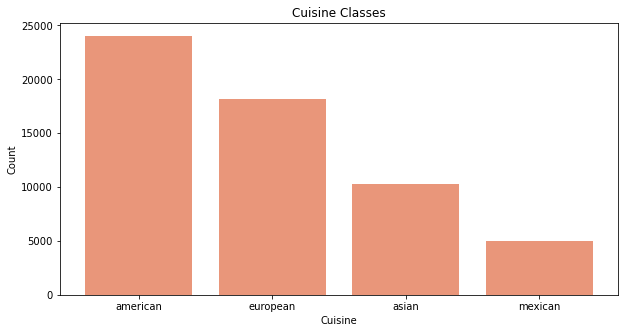

In [31]:
# Create plot showing distribution of cuisine classes
plt.figure(figsize = (10,5))
plt.bar(cuisine_classes['tags'].value_counts().index,cuisine_classes['tags'].value_counts(),color = 'darksalmon')
plt.xlabel('Cuisine')
plt.ylabel('Count')
plt.title('Cuisine Classes')
plt.show()

There seems to be a large class imbalance between the mexican and american cuisines. While I can try a number of different methods such as upsampling or down-sampling, I will decide how to proceed later on in the modelling process.

In [32]:
# Create list containing each cuisine name
cuisines = ['asian','mexican','american','european']

For this analysis, I only require the `tags` and `ingredients` columns. The rest of the columns in my `raw_recipes` dataset will be dropped. Then, a new target column will be added named `cuisine`.

In [33]:
# Only require tags and ingredients column. Drop all other columns
raw_recipes = raw_recipes.loc[:,['tags','ingredients']]

In [34]:
# Create target column
raw_recipes['cuisine'] = str('')

In [35]:
# Sanity check
raw_recipes.head()

,tags,ingredients,cuisine
0,"[60-minutes-or-less, time-to-make, course, mai...","[winter squash, mexican seasoning, mixed spice...",
1,"[30-minutes-or-less, time-to-make, course, mai...","[prepared pizza crust, sausage patty, eggs, mi...",
2,"[60-minutes-or-less, time-to-make, course, mai...","[spreadable cheese with garlic and herbs, new ...",
3,"[15-minutes-or-less, time-to-make, course, mai...","[milk, vanilla ice cream, frozen apple juice c...",
4,"[15-minutes-or-less, time-to-make, course, mai...","[fennel seeds, green olives, ripe olives, garl...",


Now that I have an empty column for my target cuisines, I can use a nested forloop to categorize each recipe, depending on which tag that they contain.

In [36]:
# Iterrate through each row and classify recipes based on 1 of 4 cuisines
for index,row in raw_recipes.iterrows():
    for y in cuisines:
        if y in row['tags']:
            raw_recipes.at[index,'cuisine'] = y

In [37]:
# Check count of cuisines
raw_recipes['cuisine'].value_counts()

            123846
american     22481
european     18213
asian         9672
mexican       4053
Name: cuisine, dtype: int64

This looks great! It looks like 123846 recipes did not contain 1 of the 4 different cuisines (American, European, Mexican, Asian), and as such they will be dropped.

In [38]:
# Convert empty strings to NaN values
raw_recipes['cuisine'].replace('', value = np.nan, inplace = True)

In [39]:
# Drop NaN values
raw_recipes.dropna(inplace = True)

Now that I have classified each recipe according to a cuisine, I can go ahead and drop the `tags` column as I will be predicting what cuisine I can create using the ingredients column.

In [40]:
# Drop tags column
raw_recipes.drop(columns = 'tags', inplace = True)

In [41]:
# Check for null values
raw_recipes.isna().sum()

ingredients    0
cuisine        0
dtype: int64

In [42]:
# Sanity Check
raw_recipes.head()

,ingredients,cuisine
0,"[winter squash, mexican seasoning, mixed spice...",mexican
1,"[prepared pizza crust, sausage patty, eggs, mi...",american
3,"[milk, vanilla ice cream, frozen apple juice c...",american
8,"[great northern bean, chicken bouillon cubes, ...",american
12,"[egg roll wrap, whole green chilies, cheese, c...",american


In [43]:
# Check shape of data
raw_recipes.shape

(54419, 2)

After classifying the recipes by a cuisine, we are left with 54419 different recipes. Now let's create our feature columns by creating a column for each individual ingredient. While pandas has a function that allows me to do this in one step (pd.get_dumm ies), this does not work well for larger datasets, so I will do this manually.

First, I will create a list of all the unique ingredients in our recipes.

In [44]:
# Create list of unique ingredients
ingredients_list = set([])

# Loop through ingredients column and add ingredients to list
for x in raw_recipes['ingredients']:
    for y in x:
        ingredients_list.add(y)

In [58]:
# Create dataframe from ingredient list
ingredients = pd.DataFrame(columns = ingredients_list)
ingredients.head()

,green onions,fresh herbs,israeli couscous,sun-dried tomatoes packed in oil with herbs,black olive paste,sweet italian turkey sausage,watermelon gelatin,hard-cooked eggs,frozen corn broccoli and red pepper,dark chocolate-covered cherries,...,baby oysters,semi-sweet chocolate bit,squirt soda,avocado oil,italian turkey sausage,lasagna sheets,blackstrap molasses,galanga powder,yellow potato,non-fat powdered milk


In [46]:
# Sanity Check
ingredients.shape

(0, 9864)

It looks like there are 9864 different columns, which means there are 9864 different ingredients used in our 54,419 recipes. Now, let's combine it with our original dataframe and name it `cuisines_df`.

In [49]:
# Concatenate our new ingredients dataframe with raw_recipes
cuisines_df = pd.concat([raw_recipes,ingredients])

# Reset index
cuisines_df.reset_index(drop = True, inplace = True)

In [50]:
# Sanity check
cuisines_df.head()

,ingredients,cuisine,green onions,fresh herbs,israeli couscous,sun-dried tomatoes packed in oil with herbs,black olive paste,sweet italian turkey sausage,watermelon gelatin,hard-cooked eggs,...,baby oysters,semi-sweet chocolate bit,squirt soda,avocado oil,italian turkey sausage,lasagna sheets,blackstrap molasses,galanga powder,yellow potato,non-fat powdered milk
0,"[winter squash, mexican seasoning, mixed spice...",mexican,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"[prepared pizza crust, sausage patty, eggs, mi...",american,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"[milk, vanilla ice cream, frozen apple juice c...",american,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,"[great northern bean, chicken bouillon cubes, ...",american,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,"[egg roll wrap, whole green chilies, cheese, c...",american,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Now that my dataframe contains my target column, as well as all the necessary feature columns, I will emulate the one-hot-encoding effect by filling the dataframe with 0 where the recipe does not contain that ingredient, and 1 if the specific recipe does contain that ingredient.

For example, at index 0, this recipe is a mexican recipe that contains winter squash, mexican seasoning, and mixed spices. Since each column is an individual ingredient, that means at the `winter squash` column, there will be a 1 instead of a 0 for this specific mexican recipe.

Our dataframe is now filled with NaN values, so let's replace these NaN values with 0 for now.

In [51]:
# Fill NaN values with 0
cuisines_df.fillna(0, inplace = True)

Now that my `cuisines_df` is filled with 0's, I will iterrate through each row. If any recipes contain a specific ingredient, I will change that value in the appropiate column to 1. To better explain this, I will use an example from the `cuisines_df` dataframe.

For example, at index 0, this recipe is a mexican recipe that contains winter squash, mexican seasoning, and mixed spices. Since each column is an individual ingredient, that means at the `winter squash` column, there will be a 1 instead of a 0 for this specific mexican recipe.

In [52]:
# Iterrate through rows and change value to 1 if recipe contains ingredient
for index, row in cuisines_df.iterrows():
    for index2,ingredient in enumerate(row['ingredients']):
        if ingredient in ingredients_list:
            cuisines_df.at[index,ingredient] = 1

Let's double check that my loop worked. Using the winter squash example, if there is a '1' at index = 0 in my winter squash column, then that means that I can continue with my analysis.

In [53]:
cuisines_df['winter squash'][0]

1

So far, it looks like it worked! However, upon checking the memory usage of my dataframe, it seems that all my feature columns are of the `int64` data type. Since all my values are 0s and 1s, we can save a significant amount of memory by reducing the datatype to `int8`.

In [54]:
# Check Dtype 
cuisines_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54419 entries, 0 to 54418
Columns: 9866 entries, ingredients to non-fat powdered milk
dtypes: int64(9864), object(2)
memory usage: 4.0+ GB


In [55]:
# Reduce Dtype of int64 -> int8
cuisines_df = cuisines_df.astype({col: 'int8' for col in cuisines_df.select_dtypes('int64').columns})

In [56]:
# Sanity check
cuisines_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54419 entries, 0 to 54418
Columns: 9866 entries, ingredients to non-fat powdered milk
dtypes: int8(9864), object(2)
memory usage: 512.8+ MB


Now that my data is ready for modelling, I will no longer require the `ingredients` column. Therefore, let's drop it from our `cuisines_df` dataframe. For ease of use, I will also save this updated dataframe to a 'csv' file named `cuisines_df.csv` and upload it to my s3 bucket. 


In [57]:
# No longer need the ingredient column
cuisines_df.drop(columns = 'ingredients', inplace = True)

In [ ]:
# Create filename
file_name = "cuisines_df.csv" 

# Save csv file
cuisines_df.to_csv(file_name)

In [ ]:
# Upload to s3 bucket
s3 = boto3.resource('s3')
s3.meta.client.upload_file(file_name, 'sam-bstncapstone-bucket', 'cuisines_df.csv')

Before continuing on to our modelling process, it is worth mentioning that up until this point, the exploratory data analysis, cleaning, and feature engineering method was also done on the recipe names, and ingredients in an attempt to create classes for each recipe. 

The top 100 recipe names were vectorized using a bag-of-words model to classify the recipes, which was then reduced to 45 classes, however upon fitting baseline models on the data (logistic regression & decision tree), the accuracies were very poor. For the ingredients classification, I attempted to classify the recipes by the most popular ingredients, however the most popular ingredients were all spices, and would not be meaningful so this method was also abandoned. Overall, the cuisine classification method was the best classification method, and the process was shown above.

# Modelling
<a id='Modelling'> </a>

In [59]:
# Import necessary sklearn libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.ensemble import RandomForestClassifier
import joblib

In [60]:
# Create train and test split
X = cuisines_df.drop(columns = 'cuisine')
y = cuisines_df['cuisine']
X_remainder,X_test,y_remainder,y_test = train_test_split(X,y,test_size = 0.2, random_state = 1)

In [61]:
# Create validation set
X_train,X_validation,y_train,y_validation = train_test_split(X_remainder,y_remainder, test_size = 0.3, random_state = 3)

First, let's run PCA on my train and validation set to see if I can reduce the dimensions of my data.

In [62]:
# Instantiate and fit to scaled training data
vote_pca = PCA(n_components=None).fit(X_train)


# Transform train and test sets 
X_remainder_PC = vote_pca.transform(X_remainder)
X_test_PC = vote_pca.transform(X_test)
X_train_PC = vote_pca.transform(X_train)
X_validation_PC = vote_pca.transform(X_validation)

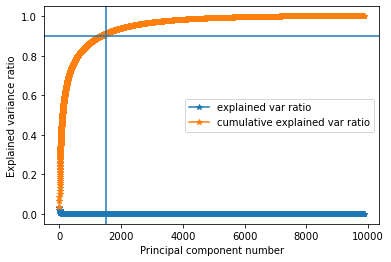

In [112]:
# Plot cumulative sum of PCA and see where pca = 0.9
num_pcs = vote_pca.components_
plt.figure()
plt.plot(range(1, len(num_pcs)+1), vote_pca.explained_variance_ratio_, label="explained var ratio", marker="*")
plt.plot(range(1, len(num_pcs)+1), vote_pca.explained_variance_ratio_.cumsum(), label="cumulative explained var ratio", marker="*")
plt.xlabel("Principal component number")
plt.ylabel("Explained variance ratio")
plt.legend()
plt.axhline(y=0.9)
plt.axvline(x = 1500)
plt.show()

Judging by the plot above, it seems that at 90% of variance is explained at approximately `PCs = 1500`.

In [113]:
# Double check PC = 1500
pca_cumulative_sum = vote_pca.explained_variance_ratio_.cumsum()
pca_cumulative_sum[1500]

0.9120142764749539

It looks like `PCs = 1500` explains 91.22% of the variance in the data. Let's continue and fit some baseline models onto my data.

# Baseline Logistic Regression Model
<a id='LR'></a>

Let's try running a baseline logistic regression with and without dimension reduction.

In [91]:
# Instantiate model
logit = LogisticRegression(max_iter = 5000)
# Fit model on train data
logit.fit(X_train_PC[:,:1501],y_train)
# Check scores
print(f'Training accuracy: {logit.score(X_train_PC[:,:1501],y_train)}')
print(f'Test accuracy: {logit.score(X_validation_PC[:,:1501],y_validation)}')

Training accuracy: 0.7781387412220253
Test accuracy: 0.7276625066993339


In [92]:
# Instantiate model
logit = LogisticRegression(max_iter = 5000)
# Fit model on train data
logit.fit(X_train,y_train)
# Check scores
print(f'Training accuracy: {logit.score(X_train,y_train)}')
print(f'Test accuracy: {logit.score(X_validation,y_validation)}')

Training accuracy: 0.836024151735906
Test accuracy: 0.735242324477452


It seems that we are able to maintain very similar accuracies when reducing the dimensions of our data. The baseline logistic regression model with PCA dimension reduction also had slightly less overfitting as well. Before making any conclusions however, I will have to optimize the model parameters to find the best possible logistic regression model.

# Pipeline and Gridsearch

As I will be running multiple models, let's create a pipeline and gridsearch to optimize my parameters. Although my feature columns are essentially all one-hot-encoded, I have chosen to test different scalers to see if it can improve my accuracies even slightly.

The models that I have chosen to train on my data are as follows:

- Logistic Regression
- Decision Tree
- Random Forest Classifier
- Neural Network

As my dataset is quite large, I will run the gridsearch on each individual model as this will be a computationally intensive process.

In [119]:
# Create estimators
estimators = [("scaler", StandardScaler()),
              ("dim_reduction", PCA()),
              ("classifier", LogisticRegression())]

# Create pipeline
my_pipeline = Pipeline(estimators)             

In [125]:
# Gridsearch for logistic regression
logit_grid = {'classifier': [LogisticRegression(max_iter = 10000, verbose = 1)], 
              'scaler': [None,StandardScaler(),MinMaxScaler(),RobustScaler()],
              'dim_reduction': [None, PCA(n_components = (1500))], 
              'classifier__C': [0.00001,0.0001,0.001, 0.01, 0.1, 1, 10, 100,1000,10000],
              'classifier__class_weight': [None,'balanced']}

# Gridsearch for decision tree
dt_grid = {'classifier': [DecisionTreeClassifier()],
           'scaler': [None,MinMaxScaler()],
           'dim_reduction': [None, PCA(n_components = (1500))], 
           'classifier__max_depth': [4,5,6,7,8,9,10,11,12,13,14,15]}

# Grid search for random forest
rf_grid = {'classifier': [RandomForestClassifier(verbose=1)],
           'scaler': [None,MinMaxScaler()],
           'dim_reduction': [None, PCA(n_components = (1500))], 
           'classifier__max_depth': [4,5,6,7,8,9,10,11,12,13,14,15],
           'classifier__n_estimators': [100,150,200]}

parameter_grid = [logit_grid,dt_grid,rf_grid]

First, I will conduct a gridsearch on my logistic regression model. I have chosen to test 3 different scalers in an attempt to see if they will improve the accuracy of my model. I will also use the `class_weight` parameter in an attempt to place a greater class weight on the `mexican` cuisine class to account for the class imbalance.

The C values of the logistic regression model will also be optimized, and I will test if dimension reduction using PCA will improve my model accuracy as well.

In [56]:
# Instantiate logistic regression gridsearch
logit_gridsearch = GridSearchCV(my_pipeline, param_grid=logit_grid, cv=5, verbose=1)

In [58]:
# Fit train data onto gridsearch
logit_gridsearch.fit(X_remainder, y_remainder)

Fitting 5 folds for each of 160 candidates, totalling 800 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.0s finished
[Parallel(n_j

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('dim_reduction', PCA()),
                                       ('classifier', LogisticRegression())]),
             param_grid={'classifier': [LogisticRegression(C=1, max_iter=10000,
                                                           verbose=1)],
                         'classifier__C': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1,
                                           10, 100, 1000, 10000],
                         'classifier__class_weight': [None, 'balanced'],
                         'dim_reduction': [None, PCA(n_components=1500)],
                         'scaler': [None, StandardScaler(), MinMaxScaler(),
                                    RobustScaler()]},
             verbose=1)

In [164]:
# Print accuracy scores
print(logit_gridsearch.best_estimator_.score(X_remainder, y_remainder))
print(logit_gridsearch.best_estimator_.score(X_test, y_test))

0.823659124842081
0.7456817346563763


It looks like the best test accuracy score for my logistic regression model will be 74.57%. There is still some slight overfitting on my training data, however I will test my other  models to see if there are better results.

In [60]:
# View best estimators
logit_gridsearch.best_estimator_

Pipeline(steps=[('scaler', None), ('dim_reduction', None),
                ('classifier',
                 LogisticRegression(C=1, max_iter=10000, verbose=1))])

In [62]:
# View best parameters
logit_gridsearch.best_params_

{'classifier': LogisticRegression(C=1, max_iter=10000, verbose=1),
 'classifier__C': 1,
 'classifier__class_weight': None,
 'dim_reduction': None,
 'scaler': None}

It took approximately 36 hours for my gridsearch to optimize my logistic regression model. Based on this, I will not run a gridsearch on my neural network and random forest classifier, as this will take too much time (This is something I can re-visit in the future). 

Based on my gridsearch, the best parameters for my logistic regression will be:

- **C value** = 1
- **Class_weight** = None
- **Dimension reduction** = None
- **Scaler** = None

Let's save the results of this gridsearch in case I require it in the future.

In [55]:
#save your model or results
joblib.dump(logit_gridsearch.best_estimator_, 'gridsearchlogitbestestimator.pkl')

#save your model or results
joblib.dump(logit_gridsearch.best_params_,"gridsearchlogitbestparam.pkl")

#save your model or results
joblib.dump(logit_gridsearch.best_estimator_.score(X_test,y_test), 'gridsearchlogittestscore.pkl')
joblib.dump(logit_gridsearch.best_estimator_.score(X_remainder,y_remainder), 'gridsearchlogittrainscore.pkl')

#save your model or results
joblib.dump(logit_gridsearch,"gridsearchlogit.pkl")

# save the gridsearch_model to disk
filename = 'trained_cuisines_gridsearch.sav'
pickle.dump(logit_gridsearch, open(filename, 'wb'))

NameError: name 'cuisines_gridsearch' is not defined

The error I'm receiving here is because I re-ran the code by accident after re-naming the variables. Please ignore this error.

In [79]:
# Reload model code - incase I need to reload my gridsearch
#gridsearch_model_reloaded = pickle.load(open('trained_cuisines_gridsearch.sav', 'rb'))

# Final Logistic Regression Model based on GridSearch

In [93]:
# Instantiate model
mylogit = LogisticRegression(C = 1, max_iter = 10000, verbose = 1)

# Fit model
mylogit.fit(X_remainder,y_remainder)

# Scores
print(f'The training accuracy is: {mylogit.score(X_remainder,y_remainder)}')
print(f'The test accuracy is: {mylogit.score(X_test,y_test)}')

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.7min finished


The training accuracy is: 0.8227632939014586
The test accuracy is: 0.7417309812568909


In [114]:
# Instantiate model
mylogit = LogisticRegression(C = 1, max_iter = 10000, verbose = 1)

# Fit model
mylogit.fit(X_remainder_PC[:,:1501],y_remainder)

# Scores
print(f'The training accuracy is: {mylogit.score(X_remainder_PC[:,:1501],y_remainder)}')
print(f'The test accuracy is: {mylogit.score(X_test_PC[:,:1501],y_test)}')

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


The training accuracy is: 0.7694728379464798
The test accuracy is: 0.7386071297317163


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   15.7s finished


As mentioned earlier, this is the optimized logistic regression model scores. Interestingly enough, we were able to maintain almost the exact same test accuracy and less overfitting on the train data when using PCA dimension reduction (PCs = 1500). Although we are sacrificing approximately 0.3% test accuracies as well as some interpretability, we are able to reduce our the dimensions of our features by a large margin. This reduces the computational cost of our model, which would be useful especially if we were to incorporate more cuisines and recipes to our dataset.   

Since this is a multiclass problem, I will need to also view the precision and recall values, as well as a confusion matrix to ensure that my model is accurately predicting each cuisine class.

In [67]:
# Create y_pred variables
y_pred_train = mylogit.predict(X_remainder)
y_pred_test = mylogit.predict(X_test)

# Show classification report of precision and recall values
print("TRAIN SET")
print(classification_report(y_remainder, y_pred_train))
# TEST
print("TEST SET")
print(classification_report(y_test, y_pred_test))

TRAIN SET
              precision    recall  f1-score   support

    american       0.80      0.83      0.82     17982
       asian       0.91      0.88      0.89      7747
    european       0.82      0.83      0.82     14523
     mexican       0.77      0.65      0.70      3283

    accuracy                           0.82     43535
   macro avg       0.82      0.80      0.81     43535
weighted avg       0.82      0.82      0.82     43535

TEST SET
              precision    recall  f1-score   support

    american       0.72      0.76      0.74      4499
       asian       0.86      0.80      0.83      1925
    european       0.75      0.76      0.75      3690
     mexican       0.60      0.49      0.54       770

    accuracy                           0.75     10884
   macro avg       0.73      0.70      0.71     10884
weighted avg       0.75      0.75      0.74     10884



As seen in the recall values of the classification report above, the logistic regression model does decently when classifying American, European, and Asian cuisine classes. It does however struggle with the mexican cuisine. Let's look at the confusion matrix to view what is happening with my model.

In [83]:
# Create confusion matrix
conf_matrix = confusion_matrix(y_test,y_pred_test)
conf_matrix

array([[3405,  135,  717,  242],
       [ 207, 1541,  172,    5],
       [ 789,  102, 2791,    8],
       [ 316,   20,   55,  379]], dtype=int64)

In [98]:
# Normalize confusion matrix
normalized_conf_mat = conf_matrix/conf_matrix.astype(np.float).sum(axis=1, keepdims=True)
normalized_conf_mat

array([[0.75683485, 0.03000667, 0.15936875, 0.05378973],
       [0.10753247, 0.80051948, 0.08935065, 0.0025974 ],
       [0.21382114, 0.02764228, 0.75636856, 0.00216802],
       [0.41038961, 0.02597403, 0.07142857, 0.49220779]])

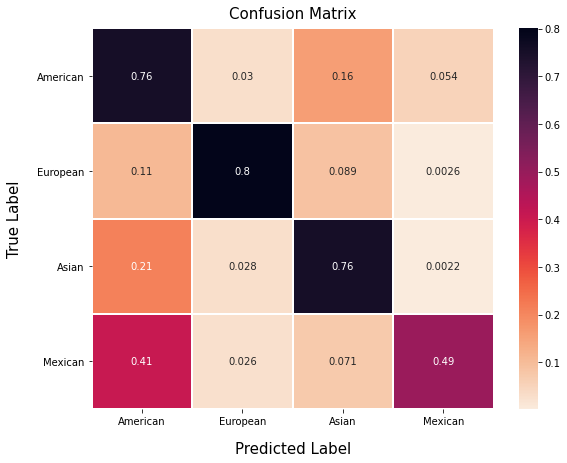

In [99]:
# Plot confusion matrix
plt.figure(figsize = (9,7))

sns.heatmap(normalized_conf_mat,
            annot=True,
            cbar=True,
            cmap="rocket_r",
            linewidths=1
           )
plt.xlabel("Predicted Label", size = 15, labelpad = 15)
plt.ylabel("True Label", size = 15, labelpad = 15)
plt.title('Confusion Matrix',size =15,y = 1.01)
plt.xticks(ticks = np.arange(4)+0.5, labels = ['American','European','Asian','Mexican'])
plt.yticks(ticks = np.arange(4)+0.5, labels = ['American','European','Asian','Mexican'],rotation = 0)
plt.show()

It looks like my logistic regression model has some issues classifying each cuisine class. It looks like my model to some degree is misclassifying each cuisine as american. However, it seems this issue is most glaring when looking at the mexican cuisine. Some possible explanations for this could be:

- The class imbalance between american and mexican cuisine can perhaps contribute to this misclassification
- Perhaps the ingredients and spices used in the american cuisine are also common in mexican cuisine as well

# Decision Tree
<a id='DT'></a>

In [116]:
# Instantiate DT model
my_dt = DecisionTreeClassifier()

# Fit
my_dt.fit(X_train,y_train)

# Accuracy Score
print(f'Train accuracy: {my_dt.score(X_train,y_train)}')
print(f'Test accuracy: {my_dt.score(X_validation,y_validation)}')

Train accuracy: 0.9997702959900243
Test accuracy: 0.6270576525534033


In [118]:
# Instantiate DT model
my_dt = DecisionTreeClassifier()

# Fit
my_dt.fit(X_train_PC[:,:1501],y_train)

# Accuracy Score
print(f'Train accuracy: {my_dt.score(X_train_PC[:,:1501],y_train)}')
print(f'Test accuracy: {my_dt.score(X_validation_PC[:,:1501],y_validation)}')

Train accuracy: 0.9997702959900243
Test accuracy: 0.48801776280529824


For our baseline model, we were able to achieve an accuracy of 62.70% on our validation set without PCA, and 48.80% with PCA. Our baseline decision trees obviously had overfitting issues as we did not set a max depth. Let's try optimizing our `max_depth` parameter to reduce the overfitting of the decision tree.

In [128]:
%%time
# Create list of depth values to test DT model on
tree_depth = np.arange(1,50)

# Create lists to score train and validation scores
train_scores = []
validation_scores = []

for d in tree_depth:
    
    # Instantiate DT
    my_dt = DecisionTreeClassifier(max_depth = d)
    
    # Fit 
    my_dt.fit(X_train,y_train)
    
    # Append validation and train scores to lists.
    train_scores.append(my_dt.score(X_train,y_train))
    validation_scores.append(my_dt.score(X_validation,y_validation))


Wall time: 13min 48s


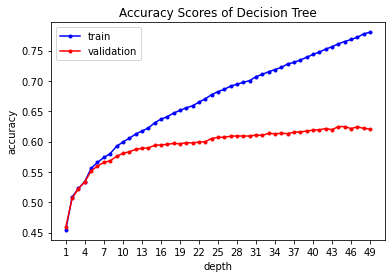

In [129]:
# Plot Train and Validation Scores of Various Tree Depths
plt.figure()
plt.plot(tree_depth,train_scores,c = 'blue',label = 'train',marker = '.')
plt.plot(tree_depth,validation_scores,c = 'red',label = 'validation',marker = '.')
plt.xlabel('depth')
plt.ylabel('accuracy')
plt.xticks(np.arange(1,50,3))
plt.title('Accuracy Scores of Decision Tree')
plt.
plt.legend()
plt.show()

It seems that at approximately `max_depth = 8` , we achieve the best validation accuracy while minimizing overfitting. Let's try using these parameters in on our test data.

In [61]:
# Instantiate DT model
final_dt = DecisionTreeClassifier(max_depth = 8)

# Fit
final_dt.fit(X_remainder,y_remainder)

# Accuracy Score
print(f'Train accuracy: {final_dt.score(X_remainder,y_remainder)}')
print(f'Test accuracy: {final_dt.score(X_test,y_test)}')

Train accuracy: 0.5778568967497416
Test accuracy: 0.5613744946710768


After optimizing our decision tree (without PCA), we achieve a test accuracy of 56.14%. Overall, this model performed worse than the logistic regression model, however we will try the decision tree model with PCA.

In [130]:
%%time
# Create list of depth values to test DT model on
tree_depth = np.arange(1,50)

# Create lists to score train and validation scores
train_scores_PC = []
validation_scores_PC = []

for d in tree_depth:
    
    # Instantiate DT
    my_dt_pca = DecisionTreeClassifier(max_depth = d)
    
    # Fit 
    my_dt_pca.fit(X_train_PC[:,:1501],y_train)
    
    # Append validation and train scores to lists.
    train_scores_PC.append(my_dt_pca.score(X_train_PC[:,:1501],y_train))
    validation_scores_PC.append(my_dt_pca.score(X_validation_PC[:,:1501],y_validation))


Wall time: 42min 10s


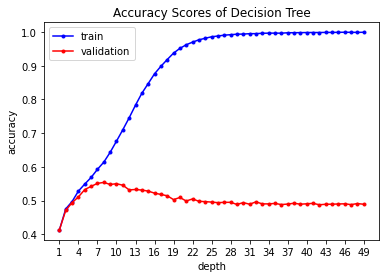

In [131]:
# Plot Train and Validation Scores of Various Tree Depths
plt.figure()
plt.plot(tree_depth,train_scores_PC,c = 'blue',label = 'train',marker = '.')
plt.plot(tree_depth,validation_scores_PC,c = 'red',label = 'validation',marker = '.')
plt.xlabel('depth')
plt.ylabel('accuracy')
plt.xticks(np.arange(1,50,3))
plt.title('Accuracy Scores of Decision Tree')
plt.legend()
plt.show()

The plot above indicates the train and validation scores with PCA after testing various max_depth values. It seems that similar to the previous decision tree, a `max_depth` of approximately 7 would minimize overfitting on the train data.

In [63]:
# Instantiate DT model
final_dt_PC = DecisionTreeClassifier(max_depth = 7)

# Fit
final_dt_PC.fit(X_remainder_PC[:,:1501],y_remainder)

# Accuracy Score
print(f'Train accuracy: {final_dt_PC.score(X_remainder_PC[:,:1501],y_remainder)}')
print(f'Test accuracy: {final_dt_PC.score(X_test_PC[:,:1501],y_test)}')

Train accuracy: 0.5812105202710462
Test accuracy: 0.5520948180815877


Again, very similar accuracies to our previous decision tree model, however with slightly more overfitting and a lower test accuracy.

# Random Forest Classifier
<a id='RF'></a>

Let's try running a random forest classifier and see if this ensemble model is able to improve upon my decision tree accuracies.

In [67]:
# Instantiate DT model
my_rf = RandomForestClassifier()

# Fit
my_rf.fit(X_train,y_train)

# Accuracy Score
print(f'Training Accuracy: {my_rf.score(X_train,y_train)}')
print(f'Test Accuracy: {my_rf.score(X_validation,y_validation)}')

Training Accuracy: 0.9997702959900243
Test Accuracy: 0.7084449888982467


In [68]:
%%time
# Create list of depth values to test DT model on
tree_depth = np.arange(1,30)

# Create lists to score train and validation scores
train_scores = []
validation_scores = []

for d in tree_depth:
    
    # Instantiate DT
    my_dt = RandomForestClassifier(n_estimators = 150, max_depth = d)
    
    # Fit 
    my_dt.fit(X_train,y_train)
    
    # Append validation and train scores to lists.
    train_scores.append(my_dt.score(X_train,y_train))
    validation_scores.append(my_dt.score(X_validation,y_validation))


Wall time: 10min 35s


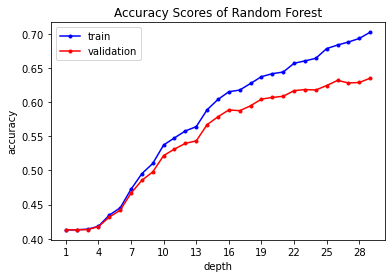

In [69]:
# Plot Train and Validation Scores of Various Tree Depths
plt.figure()
plt.plot(tree_depth,train_scores,c = 'blue',label = 'train',marker = '.')
plt.plot(tree_depth,validation_scores,c = 'red',label = 'validation',marker = '.')
plt.xlabel('depth')
plt.ylabel('accuracy')
plt.xticks(np.arange(1,31,3))
plt.title('Accuracy Scores of Random Forest')
plt.legend()
plt.show()

In [72]:
# Instantiate DT model
my_rf = RandomForestClassifier(n_estimators = 150, max_depth = 17)

# Fit
my_rf.fit(X_remainder,y_remainder)

# Accuracy Score
print(my_rf.score(X_remainder,y_remainder))
print(my_rf.score(X_test,y_test))

0.6111404616974848
0.5924292539507534


Overall, our optimized random forest model did not have the best performance with a 59.24% accuracy. While there was minimal overfitting, our model had a poor training accuracy most likely due to the lower `max_depth` value. As we can see from the plot above, increasing the `max_depth` value increases our models training accuracy, however it also increases the overfitting of our model on our training data.

# Random Forest with PCA

In [65]:
# Instantiate DT model
my_rf_PC = RandomForestClassifier()
# Fit
my_rf_PC.fit(X_remainder_PC[:,:1501],y_remainder)

# Accuracy Score
print(f'Train accuracy: {my_rf_PC.score(X_remainder_PC[:,:1501],y_remainder)}')
print(f'Test accuracy: {my_rf_PC.score(X_test_PC[:,:1501],y_test)}')

Train accuracy: 0.999563569541748
Test accuracy: 0.6568357221609702


In [72]:
%%time
# Create list of depth values to test DT model on
tree_depth = np.arange(1,30)

# Create lists to score train and validation scores
train_scores_PC = []
validation_scores_PC = []

for d in tree_depth:
    
    # Instantiate DT
    my_rf_PC = RandomForestClassifier(n_estimators = 150, max_depth = d)
    
    # Fit 
    my_rf_PC.fit(X_train_PC[:,:1501],y_train)
    
    # Append validation and train scores to lists.
    train_scores_PC.append(my_rf_PC.score(X_train_PC[:,:1501],y_train))
    validation_scores_PC.append(my_rf_PC.score(X_validation_PC[:,:1501],y_validation))


Wall time: 1h 1min 51s


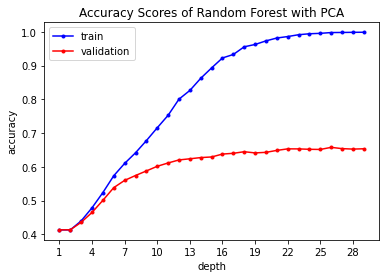

In [73]:
# Plot Train and Validation Scores of Various Tree Depths
plt.figure()
plt.plot(tree_depth,train_scores_PC,c = 'blue',label = 'train',marker = '.')
plt.plot(tree_depth,validation_scores_PC,c = 'red',label = 'validation',marker = '.')
plt.xlabel('depth')
plt.ylabel('accuracy')
plt.xticks(np.arange(1,31,3))
plt.title('Accuracy Scores of Random Forest with PCA')
plt.legend()
plt.show()

In [74]:
# Instantiate DT model
my_rf_PC = RandomForestClassifier(max_depth = 7, n_estimators = 150)
# Fit
my_rf_PC.fit(X_remainder_PC[:,:1501],y_remainder)

# Accuracy Score
print(f'Train accuracy: {my_rf_PC.score(X_remainder_PC[:,:1501],y_remainder)}')
print(f'Test accuracy: {my_rf_PC.score(X_test_PC[:,:1501],y_test)}')

Train accuracy: 0.5988514987940737
Test accuracy: 0.5622013965453877


Similar results to our previous random forest model, however this is acceptable given that we are able to reduce the dimensions of our data substantially. As our ensemble model and decision tree had poor performances, we will use either the logistic regression or neural network as our final model.